# YELP AND FOURSQUARE EDA
-----

In [1]:
# imports
# import plotly.express as px
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)
import requests
# import datetime
import json
# import time
# from pprint import pprint

In [2]:
save_num_ll = 0
save_num_lat = 0
save_num_long = 0
save_num_df_fsq = 0
save_num_df_yelp = 0

In [3]:
# Import data from file
df = pd.read_csv('data/df_citybikes.csv')

# Foursquare

Send a request to Foursquare with a small radius (1000m) for all the bike stations in your city of choice. 

In [4]:
import os

# Define a function to return a list of dictionaries with information about the requested city
def station_loci(ll_value):
    ''' a function that takes string lat-long as '0.00,-0.00' as it's only argument, 
    and returns a DataFrame object with the following parameters
    '''
    api_key = os.environ["FOURSQUARE_API_KEY"]
    fields = 'fsq_id,name,location,geocodes,categories,distance,rating,stats,hours,price,popularity'
    fsq_data_url = (f'https://api.foursquare.com/v3/places/search?ll={ll_value}&fields={fields}&radius=1000')
    headers = {
        "accept": "application/json",
        "Authorization": api_key
    }
    fsq_loci_results = requests.get(fsq_data_url, headers=headers).json()

    list_of_dict = []
    for poi in fsq_loci_results['results']:
        categories = poi.get('categories', None)
        cat_id = categories[0]['id'] if len(categories) > 0 else None
        category_name = categories[0]['name'] if len(categories) > 0 else None

        loci_poi_dict = {
              'lat-long': f'{ll_value}'
            , 'fsq_id': poi['fsq_id']
            , 'cat_id': cat_id
            , 'category_name': category_name
            , 'categories': categories
            , 'name': poi.get('name', None)
            , 'distance': poi.get('distance', None)
            , 'latitude': poi.get('geocodes', {}).get('main', {}).get('latitude', None)
            , 'longitude': poi.get('geocodes', {}).get('main', {}).get('longitude', None)
            , 'address': poi.get('location', {}).get('formatted_address', None)
            , 'popularity': poi.get('popularity', None)
            , 'price': poi.get('price', None)
            , 'open_now': poi.get('hours', {}).get('open_now', None)
            , 'rating': poi.get('rating', None)
            , 'rating_count': poi.get('stats', {}).get('total_ratings', None)
            # , 'address': poi['location']['address']
            # , 'country': poi['location']['country']
            # , 'cross_street': poi['location']['cross_street']
            # , 'locality': poi['location']['locality']
            # , 'region': poi['location']['region']
            # , 'postcode': poi['location']['postcode']
            # , 'timezone': poi['timezone']
            # , 'link': poi['link']
        }
        list_of_dict.append(loci_poi_dict)
    return pd.DataFrame(list_of_dict)

In [5]:
test_ll = station_loci('49.262487,-123.114397')
test_ll.head(2)

,lat-long,fsq_id,cat_id,category_name,categories,name,distance,latitude,longitude,address,popularity,price,open_now,rating,rating_count
0,"49.262487,-123.114397",4fd3a01be4b0540d9cb027ea,13034,Café,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi...",Moii Cafe,57,49.262562,-123.115171,"2559 Cambie St (btwn W Broadway & W 10th Ave),...",0.221702,1.0,True,8.0,55
1,"49.262487,-123.114397",4b1db335f964a520211424e3,13034,Café,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi...",Marulilu Cafe,96,49.263364,-123.113942,"451W Broadway W (at Cambie St), Vancouver BC V...",0.953849,2.0,True,8.2,111


In [6]:
# Create a new column with the coordinate data we need, reformated to str dtype.

# Grab just the two columns we need lat and lon
df.dropna(subset=['latitude', 'longitude'], inplace=True)

# Creation of a new variable with lon and lat together, label the column header 'll'
df['ll'] = df['latitude'].astype(str) + ',' + df['longitude'].astype(str)
df = df[df['ll'] != '0.0,0.0']
print(df.shape)
print(df.dtypes)
df.head(2)

# Reference from Data wrangling exercise

(241, 11)
Station Name     object
slots             int64
empty_slots       int64
free_bikes        int64
status           object
bank_card        object
latitude        float64
longitude       float64
timestamp        object
Unique ID         int64
ll               object
dtype: object


,Station Name,slots,empty_slots,free_bikes,status,bank_card,latitude,longitude,timestamp,Unique ID,ll
0,0001 10th & Cambie,35,16,19,online,No,49.262487,-123.114397,2022-11-07T17:29:02.108000Z,1,"49.262487,-123.114397"
1,0004 Yaletown-Roundhouse Station,16,2,14,online,No,49.274566,-123.121817,2022-11-07T17:29:02.153000Z,4,"49.274566,-123.121817"


In [7]:
# Create a series of ll, confirm format for api url
ll = df['ll']
ll.head(2)

0    49.262487,-123.114397
1    49.274566,-123.121817
Name: ll, dtype: object

In [8]:
# Populate an empty list with the pd.df objects from each ll location:
df_list = []
for loci in ll:
    next = station_loci(loci)
    df_list.append(next)

In [9]:
# Refresh df objects to avoid duplication
df_fsq = pd.DataFrame()
x = pd.DataFrame()

# Generate full df object with all locations through concatenation 
for df_loci in df_list:
    x = pd.concat([df_fsq, df_loci])
    df_fsq = x

In [10]:
# Confirm success
df_fsq.shape

(2410, 15)

In [11]:
# Save the new df
df_fsq.to_csv(f'data/df_fsq{save_num_df_fsq}.csv', index=False)
save_num_df_fsq += 1

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

Put your parsed results into a DataFrame

In [12]:
# Providing top 10 results of the DataFrame
df_fsq.head(10)

,lat-long,fsq_id,cat_id,category_name,categories,name,distance,latitude,longitude,address,popularity,price,open_now,rating,rating_count
0,"49.262487,-123.114397",4fd3a01be4b0540d9cb027ea,13034.0,Café,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi...",Moii Cafe,57,49.262562,-123.115171,"2559 Cambie St (btwn W Broadway & W 10th Ave),...",0.221702,1.0,True,8.0,55.0
1,"49.262487,-123.114397",4b1db335f964a520211424e3,13034.0,Café,"[{'id': 13034, 'name': 'Café', 'icon': {'prefi...",Marulilu Cafe,96,49.263364,-123.113942,"451W Broadway W (at Cambie St), Vancouver BC V...",0.953849,2.0,True,8.2,111.0
2,"49.262487,-123.114397",4db0b65d4df03036e8c0960c,11064.0,Hair Salon,"[{'id': 11064, 'name': 'Hair Salon', 'icon': {...",Space Salon,128,49.263102,-123.115785,"530W Broadway W (btw Ash & Cambie), Vancouver ...",0.785993,NaN,False,8.3,12.0
3,"49.262487,-123.114397",4bc290d674a9a593788ed3f6,11046.0,Banking and Finance,"[{'id': 11046, 'name': 'Banking and Finance', ...",Vancity Savings Credit Union,48,49.262392,-123.115157,"501 10th Ave W, Vancouver BC V5Z 1K9",0.944987,NaN,True,7.2,8.0
4,"49.262487,-123.114397",4e223f06d4c0d32590f80ff4,13306.0,Taco Restaurant,"[{'id': 13306, 'name': 'Taco Restaurant', 'ico...",La Taqueria Pinche Taco Shop,164,49.263601,-123.112665,"2450 Yukon St (at W Broadway), Vancouver BC V5...",0.954043,2.0,False,8.7,367.0
5,"49.262487,-123.114397",4ab04bfaf964a520ed6620e3,13106.0,Dim Sum Restaurant,"[{'id': 13106, 'name': 'Dim Sum Restaurant', '...",Peaceful Restaurant,136,49.263087,-123.115946,"532 Broadway W (btwn Cambie & Ash), Vancouver ...",0.950837,2.0,False,8.0,205.0
6,"49.262487,-123.114397",4aa73d25f964a520704c20e3,17069.0,Grocery Store / Supermarket,"[{'id': 17069, 'name': 'Grocery Store / Superm...",Whole Foods,182,49.263993,-123.115131,"510 8th Ave W (at Cambie St), Vancouver BC V5Z...",0.996638,3.0,True,8.5,362.0
7,"49.262487,-123.114397",5a62b29f97cf5a4b8ccfc632,13276.0,Sushi Restaurant,"[{'id': 13276, 'name': 'Sushi Restaurant', 'ic...",Uma Sushi,158,49.263776,-123.113815,"450 8th Ave W, Vancouver BC V5Y 1N9",0.938808,2.0,False,7.7,8.0
8,"49.262487,-123.114397",588e7f618b0ebb5d010abac4,13272.0,Ramen Restaurant,"[{'id': 13272, 'name': 'Ramen Restaurant', 'ic...",Hokkaido Ramen Santouka,186,49.263102,-123.116677,"558 Broadway W (Cambie Street), Vancouver BC V...",0.979091,NaN,False,8.0,62.0
9,"49.262487,-123.114397",4d95113ce07ea35d25829f02,17033.0,Department Store,"[{'id': 17033, 'name': 'Department Store', 'ic...",Winners & HomeSense,191,49.264049,-123.114244,"491 8th Ave W (Cambie), Vancouver BC V5Y 3Z5",0.889489,NaN,True,8.0,21.0


# Yelp

Send a request to Yelp with a small radius (1000m) for all the bike stations in your city of choice. 

In [13]:
#define a function to return a list of dictionaries with information about the requested city

import requests
import os


def station_loci(lat, long):
    ''' a function that takes string lat and long as '0.00', and '-0.00' as it's arguments, 
    and returns a DataFrame object with the following parameters
    '''
    api_key = os.environ["YELP_API_KEY"]
    yelp_data_url = (f'https://api.yelp.com/v3/businesses/search?latitude={lat}&longitude={long}&radius=1000')
    payload={}
    headers = {
        'accept': 'application/json',             #Incorporate headers and API key
        'Authorization': f'Bearer {api_key}'
    }
    yelp_loci_results = requests.get(yelp_data_url, headers=headers, data=payload).json()           #Perform get request

    list_of_dict = []
    for poi in yelp_loci_results["businesses"]:
        loci_poi_dict = {
              'lat-long': f'{lat}, {long}'
            , 'category_name': poi['categories'][0]['alias']
            , 'categories': poi['categories']
            , 'name': poi['name']
            , 'distance': poi['distance']
            , 'latitude': poi['coordinates']['latitude']
            , 'longitude': poi['coordinates']['longitude']
            , 'address': poi['location']['display_address']
            , 'price': poi.get('price', None)
            , 'is_closed': poi.get('is_closed')
            # , 'display_phone': poi.get('location']['display_phone')
            , 'rating': poi.get('rating')
            , 'rating_count': poi.get('review_count')
            # , 'address1': poi['location']['address1']
            # , 'country': poi['location']['country']
            # , 'city': poi['location']['city']
            # , 'state': poi['location']['state']
            # , 'zip_code': poi['location']['zip_code']
        }
        list_of_dict.append(loci_poi_dict)
    return pd.DataFrame(list_of_dict)

In [14]:
# a test run of the function
yelp_test_ll = station_loci('49.262487','-123.114397')
yelp_test_ll.head(2)

,lat-long,category_name,categories,name,distance,latitude,longitude,address,price,is_closed,rating,rating_count
0,"49.262487, -123.114397",mexican,"[{'alias': 'mexican', 'title': 'Mexican'}]",La Taqueria Pinche Taco Shop,169.517456,49.263559,-123.112736,"[2450 Yukon Street, Vancouver, BC V5Z 3V6, Can...",$$,False,4.0,668
1,"49.262487, -123.114397",chinese,"[{'alias': 'chinese', 'title': 'Chinese'}, {'a...",Peaceful Restaurant,146.418009,49.263147,-123.116143,"[110-532 W Broadway, Vancouver, BC V5Z 1E9, Ca...",$$,False,3.5,610


In [15]:
#to run location queries, we'll need the lat and log values for each station to be accessable:

# create a series of latitude:
lat = df['latitude']
print(lat.head(5))
# create a series of longitude:
long = df['longitude']
print(long.head(5))
type(long)

# Save the new series
lat.to_csv(f'data/lat_series{save_num_lat}.csv', index=False)
long.to_csv(f'data/long_series{save_num_long}.csv', index=False)
save_num_lat += 1
save_num_long += 1

0    49.262487
1    49.274566
2    49.279764
3    49.260599
4    49.264215
Name: latitude, dtype: float64
0   -123.114397
1   -123.121817
2   -123.110154
3   -123.113504
4   -123.117772
Name: longitude, dtype: float64


In [16]:
# create a while loop to run the series lat and long through the yelp api function
# This will generate a list of 241 df; one for each of the citybike.s stations

num_rows = df.shape[0]
row_counter = 0
yelp_df_list = []
while row_counter < num_rows:
    next = station_loci(lat[row_counter], long[row_counter])
    yelp_df_list.append(next)
    row_counter += 1

In [17]:
# refresh df objects to avoid duplication
df_yelp = pd.DataFrame()
x = pd.DataFrame()

# generate full df object with all locations through concatenation 
for df_loci in yelp_df_list:
    x = pd.concat([df_yelp, df_loci])
    df_yelp = x

In [18]:
# Confirm success
df_yelp.shape

(4788, 12)

In [19]:
# Save new df
df_yelp.to_csv(f'data/df_yelp{save_num_df_yelp}.csv', index=False)
save_num_df_yelp += 1

Parse through the response to get the POI (such as restaurants, bars, etc) details you want (ratings, name, location, etc)

Put your parsed results into a DataFrame

In [20]:
# Providing top 20 results of the DataFrame
df_yelp.head(20)

,lat-long,category_name,categories,name,distance,latitude,longitude,address,price,is_closed,rating,rating_count
0,"49.262487, -123.114397",mexican,"[{'alias': 'mexican', 'title': 'Mexican'}]",La Taqueria Pinche Taco Shop,169.517456,49.263559,-123.112736,"[2450 Yukon Street, Vancouver, BC V5Z 3V6, Can...",$$,False,4.0,668
1,"49.262487, -123.114397",chinese,"[{'alias': 'chinese', 'title': 'Chinese'}, {'a...",Peaceful Restaurant,146.418009,49.263147,-123.116143,"[110-532 W Broadway, Vancouver, BC V5Z 1E9, Ca...",$$,False,3.5,610
2,"49.262487, -123.114397",cafes,"[{'alias': 'cafes', 'title': 'Cafes'}]",Marulilu Cafe,102.329817,49.263380,-123.114150,"[451 W Broadway, Vancouver, BC V5Y 1R4, Canada]",$$,False,4.0,281
3,"49.262487, -123.114397",noodles,"[{'alias': 'noodles', 'title': 'Noodles'}, {'a...",Hokkaido Ramen Santouka,191.044234,49.263127,-123.116892,"[558 W Broadway, Vancouver, BC V5Z 1E9, Canada]",$$,False,4.0,218
4,"49.262487, -123.114397",japanese,"[{'alias': 'japanese', 'title': 'Japanese'}]",Saku,176.444610,49.263125,-123.116603,"[548 W Broadway, Vancouver, BC V5Z 1E9, Canada]",$$,False,4.0,182
5,"49.262487, -123.114397",indpak,"[{'alias': 'indpak', 'title': 'Indian'}]",Vij's Restaurant,547.596751,49.257540,-123.114790,"[3106 Cambie Street, Vancouver, BC V5Z 2W2, Ca...",$$$,False,4.0,366
6,"49.262487, -123.114397",coffee,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",Yolks,170.324037,49.263114,-123.116353,"[546 W Broadway, Vancouver, BC V5Z 1E9, Canada]",$$,False,3.5,336
7,"49.262487, -123.114397",desserts,"[{'alias': 'desserts', 'title': 'Desserts'}, {...",Passion8 Dessert Cafe,452.638601,49.258435,-123.114998,"[3010 Cambie Street, Vancouver, BC V5Z 2V9, Ca...",$$,False,4.0,201
8,"49.262487, -123.114397",indpak,"[{'alias': 'indpak', 'title': 'Indian'}]",Indian Roti Kitchen,391.283162,49.259010,-123.115380,"[2961 Cambie Street, Vancouver, BC V5Z 2V7, Ca...",$$,False,4.5,153
9,"49.262487, -123.114397",japanese,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",Uma Sushi,152.157897,49.263805,-123.113729,"[450 W 8th Avenue, Vancouver, BC V5Y 1N9, Canada]",$$$,False,4.5,109


# Comparing Results

In [21]:
# Number of POIs at each station?

# FourSquare API
poi_per_station_fsq = df_fsq.groupby('lat-long')
poi_per_station_fsq.count().sort_values('fsq_id', ascending=False).head(10)
# Result: 10 per station

,fsq_id,cat_id,category_name,categories,name,distance,latitude,longitude,address,popularity,price,open_now,rating,rating_count
lat-long,,,,,,,,,,,,,,
"49.238105,-123.154966",10,10,10,10,10,10,10,10,10,10,5,10,6,6
"49.271741,-123.155421",10,10,10,10,10,10,10,10,10,10,8,10,10,10
"49.277469,-123.081315",10,10,10,10,10,10,10,10,10,10,8,10,8,8
"49.277483,-123.114279",10,10,10,10,10,10,10,10,10,10,6,10,10,10
"49.277527,-123.129464",10,10,10,10,10,10,10,10,10,10,8,10,10,10
"49.277595,-123.09583",10,10,10,10,10,10,10,10,10,10,9,10,10,10
"49.277615,-123.091654",10,10,10,10,10,10,10,10,10,10,8,10,9,9
"49.277665,-123.073653",10,10,10,10,10,10,10,10,10,10,9,10,10,10
"49.277844,-123.120942",10,10,10,10,10,10,10,10,10,10,8,10,10,10


In [22]:
# Yelp API
poi_per_station_yelp = df_yelp.groupby('lat-long')
poi_per_station_yelp.count().sort_values('name', ascending=False).head(10)
# Result: 20 per station

,category_name,categories,name,distance,latitude,longitude,address,price,is_closed,rating,rating_count
lat-long,,,,,,,,,,,
"49.238105, -123.154966",20,20,20,20,20,20,20,18,20,20,20
"49.243375, -123.104978",20,20,20,20,20,20,20,18,20,20,20
"49.277436, -123.070427",20,20,20,20,20,20,20,19,20,20,20
"49.277469, -123.081315",20,20,20,20,20,20,20,18,20,20,20
"49.277483, -123.114279",20,20,20,20,20,20,20,20,20,20,20
"49.277527, -123.129464",20,20,20,20,20,20,20,20,20,20,20
"49.277595, -123.09583",20,20,20,20,20,20,20,20,20,20,20
"49.277615, -123.091654",20,20,20,20,20,20,20,20,20,20,20
"49.277665, -123.073653",20,20,20,20,20,20,20,19,20,20,20


In [24]:
# Number of reviews per POI?

# FourSquare API
reviews_per_poi_fsq = df_fsq[['fsq_id', 'name', 'rating', 'rating_count']]
reviews_per_poi_duplicated_fsq = reviews_per_poi_fsq[reviews_per_poi_fsq.duplicated()]
reviews_per_poi_no_duplicates_fsq = reviews_per_poi_duplicated_fsq.drop_duplicates()

# Look at results after duplicates removed
# reviews_per_poi_no_duplicates_fsq.sort_values('rating_count', ascending=False)
reviews_per_poi_no_duplicates_fsq.sort_values('rating_count', ascending=False)

,fsq_id,name,rating,rating_count
6,4aa7f646f964a5203d4e20e3,Granville Island Public Market,9.1,1686.0
6,4aa6f23df964a520954b20e3,Rogers Arena,8.7,1278.0
2,4aa7dce2f964a520ad4d20e3,Cafe Medina,9.0,1123.0
8,4aaa6a90f964a520df5520e3,Vancouver Aquarium,8.9,1044.0
6,4aa6f277f964a520964b20e3,BC Place,8.8,966.0
...,...,...,...,...
4,4d915e6d3dd4a0936b7a7918,English Name,NaN,NaN
6,52068e8a11d29b25bcd4ec2d,Empire QE Presentation Centre,NaN,NaN
3,4d7a8731e540f04d05a914dc,Extreme Pita,NaN,NaN
4,535d6e1e498e56c7baf842f5,BC Women's Cafeteria,NaN,NaN


           rating  rating_count
count  626.000000    626.000000
mean     8.068530     94.177316
std      0.655817    156.178008
min      5.800000      0.000000
25%      7.700000     18.000000
50%      8.100000     42.000000
75%      8.500000    101.000000
max      9.600000   1686.000000


<AxesSubplot: xlabel='rating_count'>

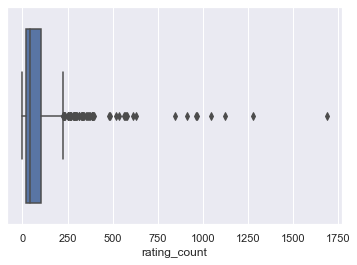

In [25]:
# Basic statistical analysis on rating count
print(reviews_per_poi_no_duplicates_fsq.sort_values('rating_count', ascending=False).describe())

# Result: 
sns.boxplot(x=reviews_per_poi_no_duplicates_fsq['rating_count'])

In [26]:
# Yelp API
reviews_per_poi_yelp = df_yelp[['name', 'rating', 'rating_count']]
reviews_per_poi_duplicated_yelp = reviews_per_poi_yelp[reviews_per_poi_yelp.duplicated()]
reviews_per_poi_no_duplicates_yelp = reviews_per_poi_duplicated_yelp.drop_duplicates()

# Look at results after duplicates removed
# reviews_per_poi_no_duplicates_yelp.sort_values('rating_count', ascending=False)

reviews_per_poi_no_duplicates_yelp.sort_values('rating_count', ascending=False)

,name,rating,rating_count
2,Medina Cafe,4.0,2504
0,Miku,4.5,2051
0,Phnom Penh,4.0,1497
1,Chambar,4.0,1495
0,Jam Cafe on Beatty,4.5,1267
...,...,...,...
17,Sabra Kosher Bakery & Restaurant,3.5,21
19,Pallet Coffee Roasters,3.5,14
17,Starbucks,4.5,7
5,Siwash Rock,4.5,5


           rating  rating_count
count  414.000000    414.000000
mean     4.086957    275.722222
std      0.385480    278.789745
min      2.500000      4.000000
25%      4.000000    102.250000
50%      4.000000    183.000000
75%      4.500000    364.000000
max      5.000000   2504.000000


<AxesSubplot: xlabel='rating_count'>

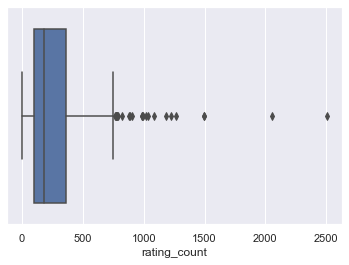

In [27]:
# Basic statistical analysis on rating count
print(reviews_per_poi_no_duplicates_yelp.sort_values('rating_count', ascending=False).describe())

# Result: 
sns.boxplot(x=reviews_per_poi_no_duplicates_yelp['rating_count'])

Which API provided you with more complete data? Provide an explanation. 

Both APIs appear to have value with different things.  yelp provides two times more POI results per input of latitude and longitude

|--------------------------------|
|    | FourSquare API | Yelp API |

Get the top 10 restaurants according to their rating

In [28]:
df_yelp.sort_values(by=['rating', 'category_name'], ascending=False).head(10)

,lat-long,category_name,categories,name,distance,latitude,longitude,address,price,is_closed,rating,rating_count
18,"49.27033, -123.10275",streetvendors,"[{'alias': 'streetvendors', 'title': 'Street V...",Johnny's Pops,1052.246707,49.277771,-123.090302,"[Vancouver, BC V6A, Canada]",$,False,5.0,82
2,"49.277469, -123.081315",streetvendors,"[{'alias': 'streetvendors', 'title': 'Street V...",Johnny's Pops,901.446270,49.277771,-123.090302,"[Vancouver, BC V6A, Canada]",$,False,5.0,82
2,"49.279369, -123.091241",streetvendors,"[{'alias': 'streetvendors', 'title': 'Street V...",Johnny's Pops,255.755370,49.277771,-123.090302,"[Vancouver, BC V6A, Canada]",$,False,5.0,82
15,"49.283992, -123.091206",streetvendors,"[{'alias': 'streetvendors', 'title': 'Street V...",Johnny's Pops,718.673135,49.277771,-123.090302,"[Vancouver, BC V6A, Canada]",$,False,5.0,82
3,"49.273777, -123.092723",streetvendors,"[{'alias': 'streetvendors', 'title': 'Street V...",Johnny's Pops,447.037606,49.277771,-123.090302,"[Vancouver, BC V6A, Canada]",$,False,5.0,82
3,"49.277595, -123.09583",streetvendors,"[{'alias': 'streetvendors', 'title': 'Street V...",Johnny's Pops,152.913685,49.277771,-123.090302,"[Vancouver, BC V6A, Canada]",$,False,5.0,82
2,"49.279235, -123.087528",streetvendors,"[{'alias': 'streetvendors', 'title': 'Street V...",Johnny's Pops,479.817198,49.277771,-123.090302,"[Vancouver, BC V6A, Canada]",$,False,5.0,82
2,"49.277333, -123.087359",streetvendors,"[{'alias': 'streetvendors', 'title': 'Street V...",Johnny's Pops,464.722795,49.277771,-123.090302,"[Vancouver, BC V6A, Canada]",$,False,5.0,82
1,"49.277615, -123.091654",streetvendors,"[{'alias': 'streetvendors', 'title': 'Street V...",Johnny's Pops,151.578373,49.277771,-123.090302,"[Vancouver, BC V6A, Canada]",$,False,5.0,82
3,"49.280852, -123.084746",streetvendors,"[{'alias': 'streetvendors', 'title': 'Street V...",Johnny's Pops,738.004461,49.277771,-123.090302,"[Vancouver, BC V6A, Canada]",$,False,5.0,82
